# Modelos del lenguaje con RNNs

En esta parte, vamos a entrenar un modelo del lenguaje basado en palabras con Recurrent Neural Networks. Asimismo, utilizaremos el modelo para generar texto. En particular, alimentaremos nuestro modelo con obras de la literatura clásica en castellano para obtener una red neuronal que sea capaz de "escribir" fragmentos literarios.

Los entrenamientos para obtener un modelo de calidad podrían tomar cierto tiempo (5-10 minutos por epoch), por lo que se aconseja empezar a trabajar pronto. El uso de GPUs no ayuda tanto con LSTMs como con CNNs, por lo que si tenéis máquinas potentes en casa es posible que podáis entrenar más rápido o a la misma velocidad que en Colab. En todo caso, la potencia de Colab es más que suficiente para completar esta actividad con éxito.

<center><img src="https://upload.wikimedia.org/wikipedia/commons/d/d8/El_ingenioso_hidalgo_don_Quijote_de_la_Mancha.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consistirá en un archivo de texto con el contenido íntegro en castellano antiguo de El Ingenioso Hidalgo Don Quijote de la Mancha, disponible de manera libre en la página de [Project Gutenberg](https://www.gutenberg.org). Asimismo, como apartado optativo en este laboratorio se pueden utilizar otras fuentes de texto. Aquí podéis descargar los datos a utilizar de El Quijote y un par de obras adicionales:

[El ingenioso hidalgo Don Quijote de la Mancha (Miguel de Cervantes)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219424&authkey=AH0gb-qSo5Xd7Io)


In [ ]:


# -----------------------------
# Funciones auxiliares
# -----------------------------
def loadDocument(path):
    with open(path, 'r', encoding='utf-8') as f:
        return f.read().lower()
# Limpieza del texto: Elimina signos de puntuación, caracteres especiales y saltos de línea, reemplazándolos por espacios.
def applyFilter(doc):
    # Reemplaza caracteres no ASCII y acentos
    doc = unidecode.unidecode(doc)

    # Elimina caracteres no alfabéticos (excepto puntos para separar frases)
    doc = re.sub(r"[^a-zA-Z0-9áéíóúñü\s\.]", " ", doc)

    # Reemplaza múltiples espacios por uno solo
    doc = re.sub(r"\s+", " ", doc)

    return doc.lower().strip()

# -----------------------------
# Preparación del texto
# -----------------------------
doc = loadDocument('/content/drive/MyDrive/Entrega_3/Don Quijote de la Mancha.txt')
doc = applyFilter(doc)
print(f"Longitud total del texto: {len(doc)} caracteres\n")
print("Primeros 1000 caracteres:\n")
print(doc[:1000])

tokenizer = Tokenizer(oov_token="<UNK>")
tokenizer.fit_on_texts([doc])
total_words = len(tokenizer.word_index) + 1

# Creamos secuencias de entrada de longitud creciente
input_sequences = []

for line in doc.split('.'):  # Cambié text por doc
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(2, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Padding
max_seq_len = max([len(seq) for seq in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='pre')

x = input_sequences[:, :-1]
y = input_sequences[:, -1]
print(f"Shape de X: {x.shape}")  # Cambié X por x
print(f"Shape de y: {y.shape}")

# ----- Modelo LSTM ----
# Definir dimensiones
embedding_dim = 128

# Construir el modelo
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_words, 128, input_length=x.shape[1]),
    tf.keras.layers.LSTM(200, return_sequences=False),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(total_words, activation='softmax')
])

# Compilar el modelo
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)
model.build(input_shape=(None, max_seq_len - 1))
model.summary()

# ---- Entrenamiento del modelo ----
# División de datos
split_index = int(len(x) * 0.8)
x_train, x_val = x[:split_index], x[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

# Callbacks para mejorar el entrenamiento
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/Entrega_3/quijote_model.h5',
        save_best_only=True,
        monitor='val_loss'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2
    )
]

# Entrenamiento
history = model.fit(
    x_train, y_train,  # Cambié X_train por x_train
    epochs=50,
    batch_size=64,
    validation_data=(x_val, y_val),  # Cambié X_val por x_val
    callbacks=callbacks
)

# Visualizar resultados del entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Entrega_3/training_history.png')
plt.show()

# ---- Funciones para predecir -----
def predict_next_word(seed_text, next_words=1):
    for _ in range(next_words):
        # Tokenizar el texto semilla
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        # Ajustar la longitud de la secuencia
        token_list = token_list[-max_seq_len + 1:]  # +1 porque queremos predecir la siguiente
        # Padding
        token_list = pad_sequences([token_list], maxlen=max_seq_len - 1, padding='pre')

        # Predecir la siguiente palabra
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)

        # Convertir el índice a palabra
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break

        # Añadir la palabra predicha al texto semilla
        seed_text += " " + output_word

    return seed_text

def predict_missing_word(text_with_gap, n_options=5):
    """
    Predice palabra faltante marcada con [MASK] y devuelve opciones más probables
    """
    # Separar el texto antes y después del [MASK]
    parts = text_with_gap.split("[MASK]")
    before_text = parts[0].strip()
    after_text = parts[1].strip() if len(parts) > 1 else ""

    # Tokenizar y obtener contexto
    tokens_before = tokenizer.texts_to_sequences([before_text])[0]
    # Ajustar a la longitud esperada por el modelo
    tokens_before = tokens_before[-max_seq_len + 1:]

    # Padding
    token_list = pad_sequences([tokens_before], maxlen=max_seq_len - 1, padding='pre')

    # Realizar predicción
    predictions = model.predict(token_list, verbose=0)[0]

    # Obtener las palabras más probables
    top_indices = predictions.argsort()[-n_options:][::-1]

    # Mostrar resultados
    results = []
    for idx in top_indices:
        if idx < total_words:  # Asegurarse de que el índice es válido
            for word, index in tokenizer.word_index.items():
                if index == idx:
                    results.append((word, float(predictions[idx])))
                    break

    return results

def evaluate_model_on_examples(examples):
    """
    Evalúa el modelo en una lista de ejemplos con palabras enmascaradas
    """
    for i, example in enumerate(examples):
        print(f"\nEjemplo {i+1}: {example}")
        predictions = predict_missing_word(example)
        print("Predicciones:")
        for word, prob in predictions:
            print(f"- {word} (probabilidad: {prob:.4f})")

# Ejemplos para probar el modelo
ejemplos_prueba = [
    "en un lugar de la [MASK] de cuyo nombre",  # mancha
    "don quijote de la [MASK] era un hidalgo",  #  mancha
    "se daba a leer libros de [MASK] con tanta afición",  # caballerías
    "se le secó el [MASK] de manera que vino a perder el juicio"  # cerebro/seso
]

# Probar el modelo después del entrenamiento
print("\n--- PREDICCIONES DEL MODELO ---")
evaluate_model_on_examples(ejemplos_prueba)

MessageError: Error: credential propagation was unsuccessful

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cargando y procesando texto...
Longitud total del texto: 2002635 caracteres
Número de palabras aproximado: 376225

Primeros 500 caracteres:
que trata de la condicion y ejercicio del famoso hidalgo don quijote de la mancha en un lugar de la mancha de cuyo nombre no quiero acordarme no ha mucho tiempo que vivia un hidalgo de los de lanza en astillero adarga antigua rocin flaco y galgo corredor. una olla de algo mas vaca que carnero salpicon las mas noches duelos y quebrantos los sabados lantejas los viernes algun palomino de anadidura los domingos consumian las tres partes de su hacienda. el resto della concluian sayo de velarte calza
Número total de secuencias: 376217
Vocabulario total: 25066
Shape de X: (376217, 8)
Shape de y: (376217,)
Tamaño del vocabulario: 3000
Datos de entrenamiento: (300973, 8)
Datos de validación: (75244, 8)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Iniciando entrenamiento...
Epoch 1/50
1175/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1251 - loss: 5.6463
Epoch 1: val_accuracy improved from -inf to 0.15297, saving model to /content/drive/MyDrive/Entrega_3/best_quijote_model.h5


1176/1176 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.1251 - loss: 5.6458 - val_accuracy: 0.1530 - val_loss: 5.0581 - learning_rate: 0.0010
Epoch 2/50
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1627 - loss: 4.9134
Epoch 2: val_accuracy improved from 0.15297 to 0.17455, saving model to /content/drive/MyDrive/Entrega_3/best_quijote_model.h5


1176/1176 ━━━━━━━━━━━━━━━━━━━━ 75s 36ms/step - accuracy: 0.1627 - loss: 4.9133 - val_accuracy: 0.1746 - val_loss: 4.8282 - learning_rate: 0.0010
Epoch 3/50
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1764 - loss: 4.6748
Epoch 3: val_accuracy improved from 0.17455 to 0.17664, saving model to /content/drive/MyDrive/Entrega_3/best_quijote_model.h5


1176/1176 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - accuracy: 0.1764 - loss: 4.6748 - val_accuracy: 0.1766 - val_loss: 4.7296 - learning_rate: 0.0010
Epoch 4/50
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1795 - loss: 4.5517
Epoch 4: val_accuracy improved from 0.17664 to 0.17939, saving model to /content/drive/MyDrive/Entrega_3/best_quijote_model.h5


1176/1176 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - accuracy: 0.1795 - loss: 4.5517 - val_accuracy: 0.1794 - val_loss: 4.6820 - learning_rate: 0.0010
Epoch 5/50
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.1845 - loss: 4.4715
Epoch 5: val_accuracy improved from 0.17939 to 0.18413, saving model to /content/drive/MyDrive/Entrega_3/best_quijote_model.h5


1176/1176 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.1845 - loss: 4.4715 - val_accuracy: 0.1841 - val_loss: 4.6471 - learning_rate: 0.0010
Epoch 6/50
1175/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.1887 - loss: 4.3959
Epoch 6: val_accuracy improved from 0.18413 to 0.18667, saving model to /content/drive/MyDrive/Entrega_3/best_quijote_model.h5


1176/1176 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.1887 - loss: 4.3959 - val_accuracy: 0.1867 - val_loss: 4.6210 - learning_rate: 0.0010
Epoch 7/50
1175/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1919 - loss: 4.3226
Epoch 7: val_accuracy improved from 0.18667 to 0.18966, saving model to /content/drive/MyDrive/Entrega_3/best_quijote_model.h5


1176/1176 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.1919 - loss: 4.3227 - val_accuracy: 0.1897 - val_loss: 4.6162 - learning_rate: 0.0010
Epoch 8/50
1175/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.1940 - loss: 4.2698
Epoch 8: val_accuracy improved from 0.18966 to 0.19050, saving model to /content/drive/MyDrive/Entrega_3/best_quijote_model.h5


1176/1176 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - accuracy: 0.1940 - loss: 4.2698 - val_accuracy: 0.1905 - val_loss: 4.6140 - learning_rate: 0.0010
Epoch 9/50
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1954 - loss: 4.2118
Epoch 9: val_accuracy did not improve from 0.19050
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 44s 37ms/step - accuracy: 0.1954 - loss: 4.2118 - val_accuracy: 0.1896 - val_loss: 4.6224 - learning_rate: 0.0010
Epoch 10/50
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1993 - loss: 4.1693
Epoch 10: val_accuracy improved from 0.19050 to 0.19229, saving model to /content/drive/MyDrive/Entrega_3/best_quijote_model.h5



--- PREDICCIONES EN ÉPOCA 10 ---

Texto: en un lugar de la [MASK] de cuyo nombre
Predicciones:
  - <UNK> (prob: 0.1673)
  - mancha (prob: 0.1475)
  - cual (prob: 0.0425)

Texto: don quijote de la [MASK] era un hidalgo
Predicciones:
  - mancha (prob: 0.5443)
  - <UNK> (prob: 0.0668)
  - triste (prob: 0.0607)

Texto: se daba a leer libros de [MASK] con tanta aficion
Predicciones:
  - <UNK> (prob: 0.1616)
  - caballerias (prob: 0.1234)
  - ser (prob: 0.0251)

Texto: se le seco el [MASK] de manera que vino
Predicciones:
  - <UNK> (prob: 0.1681)
  - cual (prob: 0.0923)
  - que (prob: 0.0552)
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 81s 36ms/step - accuracy: 0.1993 - loss: 4.1693 - val_accuracy: 0.1923 - val_loss: 4.6389 - learning_rate: 0.0010
Epoch 11/50
1175/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2003 - loss: 4.1195
Epoch 11: val_accuracy improved from 0.19229 to 0.19398, saving model to /content/drive/MyDrive/Entrega_3/best_quijote_model.h5


1176/1176 ━━━━━━━━━━━━━━━━━━━━ 81s 35ms/step - accuracy: 0.2003 - loss: 4.1195 - val_accuracy: 0.1940 - val_loss: 4.6532 - learning_rate: 0.0010
Epoch 12/50
1175/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2026 - loss: 4.0801
Epoch 12: val_accuracy improved from 0.19398 to 0.19519, saving model to /content/drive/MyDrive/Entrega_3/best_quijote_model.h5


1176/1176 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - accuracy: 0.2026 - loss: 4.0801 - val_accuracy: 0.1952 - val_loss: 4.6796 - learning_rate: 0.0010
Epoch 13/50
1175/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2032 - loss: 4.0418
Epoch 13: val_accuracy did not improve from 0.19519

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.2032 - loss: 4.0418 - val_accuracy: 0.1942 - val_loss: 4.7061 - learning_rate: 0.0010
Epoch 14/50
1175/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2061 - loss: 3.9798
Epoch 14: val_accuracy did not improve from 0.19519
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.2061 - loss: 3.9798 - val_accuracy: 0.1942 - val_loss: 4.7320 - learning_rate: 5.0000e-04
Epoch 15/50
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2081 - loss: 3.9500
Epoch 15: val_accuracy did not improve from 0.19519
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - accuracy: 

1176/1176 ━━━━━━━━━━━━━━━━━━━━ 83s 36ms/step - accuracy: 0.2090 - loss: 3.9177 - val_accuracy: 0.1957 - val_loss: 4.8112 - learning_rate: 5.0000e-04
Epoch 18/50
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2095 - loss: 3.9015
Epoch 18: val_accuracy did not improve from 0.19567

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 81s 35ms/step - accuracy: 0.2095 - loss: 3.9015 - val_accuracy: 0.1952 - val_loss: 4.8213 - learning_rate: 5.0000e-04
Epoch 19/50
1175/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2117 - loss: 3.8698
Epoch 19: val_accuracy did not improve from 0.19567
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - accuracy: 0.2117 - loss: 3.8698 - val_accuracy: 0.1950 - val_loss: 4.8453 - learning_rate: 2.5000e-04
Epoch 20/50
1175/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2115 - loss: 3.8495
Epoch 20: val_accuracy did not improve from 0.19567

--- PREDICCIONES EN ÉPOCA 20 ---

Texto: en un l

1176/1176 ━━━━━━━━━━━━━━━━━━━━ 83s 36ms/step - accuracy: 0.2133 - loss: 3.8488 - val_accuracy: 0.1965 - val_loss: 4.8774 - learning_rate: 2.5000e-04
Epoch 22/50
1175/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2133 - loss: 3.8412
Epoch 22: val_accuracy did not improve from 0.19648
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 81s 35ms/step - accuracy: 0.2133 - loss: 3.8412 - val_accuracy: 0.1956 - val_loss: 4.8900 - learning_rate: 2.5000e-04
Epoch 23/50
1175/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2138 - loss: 3.8245
Epoch 23: val_accuracy did not improve from 0.19648

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - accuracy: 0.2138 - loss: 3.8245 - val_accuracy: 0.1958 - val_loss: 4.9084 - learning_rate: 2.5000e-04
Epoch 24/50
1175/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2157 - loss: 3.8093
Epoch 24: val_accuracy did not improve from 0.19648
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 44s 37ms/step - ac


Epoch 28: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 84s 37ms/step - accuracy: 0.2180 - loss: 3.7829 - val_accuracy: 0.1967 - val_loss: 4.9500 - learning_rate: 1.2500e-04
Epoch 29/50
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2165 - loss: 3.7838
Epoch 29: val_accuracy did not improve from 0.19669
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 79s 35ms/step - accuracy: 0.2165 - loss: 3.7838 - val_accuracy: 0.1964 - val_loss: 4.9590 - learning_rate: 6.2500e-05
Epoch 30/50
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2178 - loss: 3.7710
Epoch 30: val_accuracy did not improve from 0.19669

--- PREDICCIONES EN ÉPOCA 30 ---

Texto: en un lugar de la [MASK] de cuyo nombre
Predicciones:
  - mancha (prob: 0.2446)
  - <UNK> (prob: 0.1429)
  - cual (prob: 0.0527)

Texto: don quijote de la [MASK] era un hidalgo
Predicciones:
  - mancha (prob: 0.7531)
  - <UNK> (prob: 0.0235)
  - triste (prob: 0.0204)

Texto: se daba a leer libros d

1176/1176 ━━━━━━━━━━━━━━━━━━━━ 83s 36ms/step - accuracy: 0.2173 - loss: 3.7739 - val_accuracy: 0.1967 - val_loss: 4.9670 - learning_rate: 6.2500e-05
Epoch 32/50
1175/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2169 - loss: 3.7719
Epoch 32: val_accuracy improved from 0.19673 to 0.19691, saving model to /content/drive/MyDrive/Entrega_3/best_quijote_model.h5


1176/1176 ━━━━━━━━━━━━━━━━━━━━ 81s 35ms/step - accuracy: 0.2169 - loss: 3.7719 - val_accuracy: 0.1969 - val_loss: 4.9721 - learning_rate: 6.2500e-05
Epoch 33/50
1175/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2171 - loss: 3.7735
Epoch 33: val_accuracy did not improve from 0.19691

Epoch 33: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - accuracy: 0.2171 - loss: 3.7735 - val_accuracy: 0.1963 - val_loss: 4.9761 - learning_rate: 6.2500e-05
Epoch 34/50
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2154 - loss: 3.7717
Epoch 34: val_accuracy did not improve from 0.19691
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.2154 - loss: 3.7717 - val_accuracy: 0.1967 - val_loss: 4.9795 - learning_rate: 3.1250e-05
Epoch 35/50
1175/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2169 - loss: 3.7642
Epoch 35: val_accuracy did not improve from 0.19691
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - ac

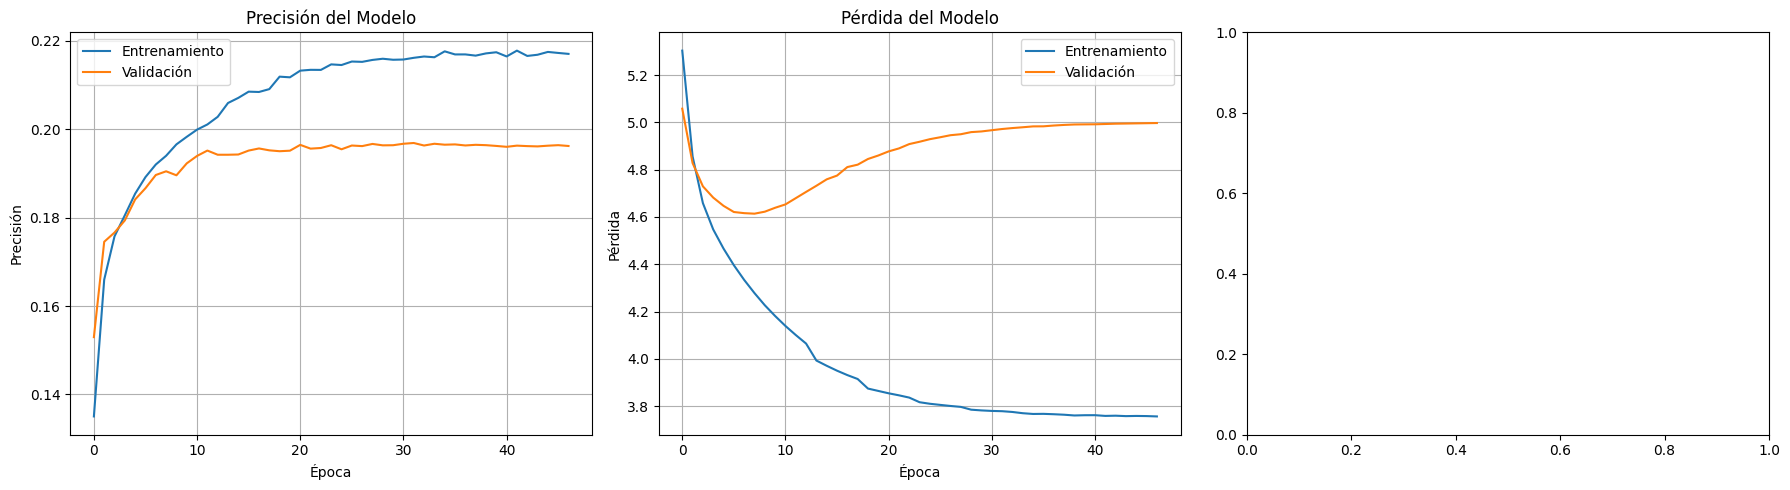

Cargando el mejor modelo guardado...



EVALUACIÓN FINAL DEL MODELO

--- Ejemplo 1 ---
Texto: en un lugar de la [MASK] de cuyo nombre
Top 5 predicciones:
  1. mancha (confianza: 0.2443)
  2. <UNK> (confianza: 0.1451)
  3. cual (confianza: 0.0515)
  4. ciudad (confianza: 0.0279)
  5. venta (confianza: 0.0241)

--- Ejemplo 2 ---
Texto: don quijote de la [MASK] era un hidalgo
Top 5 predicciones:
  1. mancha (confianza: 0.7172)
  2. <UNK> (confianza: 0.0283)
  3. cual (confianza: 0.0207)
  4. triste (confianza: 0.0199)
  5. duena (confianza: 0.0128)

--- Ejemplo 3 ---
Texto: se daba a leer libros de [MASK] con tanta aficion
Top 5 predicciones:
  1. caballerias (confianza: 0.5186)
  2. <UNK> (confianza: 0.1128)
  3. caballerias. (confianza: 0.0266)
  4. su (confianza: 0.0226)
  5. que (confianza: 0.0176)

--- Ejemplo 4 ---
Texto: se le seco el [MASK] de manera que vino
Top 5 predicciones:
  1. <UNK> (confianza: 0.2029)
  2. cual (confianza: 0.1465)
  3. que (confianza: 0.0385)
  4. ventero (confianza: 0.0270)
  5. cura (confianz

In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import re
import os
from datetime import datetime
try:
    import unidecode
except ImportError:
    !pip install unidecode
    import unidecode

# -----------------------------
# Funciones auxiliares mejoradas
# -----------------------------
def loadDocument(path):
    """Carga el documento de texto"""
    with open(path, 'r', encoding='utf-8') as f:
        return f.read()

def applyFilter(doc):
    """Limpieza y normalización del texto"""
    # Convertir a minúsculas
    doc = doc.lower()

    # Reemplaza caracteres no ASCII y acentos
    doc = unidecode.unidecode(doc)

    # Eliminar números y caracteres especiales, mantener solo letras y espacios
    doc = re.sub(r"[^a-zA-Z\s\.]", "", doc)

    # Reemplazar múltiples espacios por uno solo
    doc = re.sub(r"\s+", " ", doc)

    # Eliminar líneas muy cortas (menos de 3 palabras)
    lines = doc.split('.')
    filtered_lines = [line.strip() for line in lines if len(line.strip().split()) > 3]

    return '. '.join(filtered_lines)

def create_sequences(text, tokenizer, seq_length=10):
    """Crear secuencias de entrenamiento con longitud fija"""
    # Tokenizar todo el texto
    tokens = tokenizer.texts_to_sequences([text])[0]

    # Crear secuencias de longitud fija
    sequences = []
    for i in range(seq_length, len(tokens)):
        seq = tokens[i-seq_length:i+1]  # seq_length + 1 elementos
        sequences.append(seq)

    return sequences

# -----------------------------
# Callback personalizado para predicciones cada 10 épocas
# -----------------------------
class PredictionCallback(tf.keras.callbacks.Callback):
    def __init__(self, tokenizer, max_seq_len, examples):
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        self.examples = examples

    def predict_missing_word(self, text_with_gap, n_options=3):
        """Predice palabra faltante"""
        parts = text_with_gap.split("[MASK]")
        before_text = parts[0].strip()

        tokens_before = self.tokenizer.texts_to_sequences([before_text])[0]
        tokens_before = tokens_before[-(self.max_seq_len-1):]

        token_list = pad_sequences([tokens_before], maxlen=self.max_seq_len-1, padding='pre')

        predictions = self.model.predict(token_list, verbose=0)[0]
        top_indices = predictions.argsort()[-n_options:][::-1]

        results = []
        for idx in top_indices:
            for word, index in self.tokenizer.word_index.items():
                if index == idx:
                    results.append((word, float(predictions[idx])))
                    break
        return results

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 10 == 0:
            print(f"\n--- PREDICCIONES EN ÉPOCA {epoch + 1} ---")
            for example in self.examples:
                print(f"\nTexto: {example}")
                predictions = self.predict_missing_word(example)
                print("Predicciones:")
                for word, prob in predictions:
                    print(f"  - {word} (prob: {prob:.4f})")

# -----------------------------
# Preparación del texto
# -----------------------------
print("Cargando y procesando texto...")
doc = loadDocument('/content/drive/MyDrive/Entrega_3/Don Quijote de la Mancha.txt')
doc = applyFilter(doc)

print(f"Longitud total del texto: {len(doc)} caracteres")
print(f"Número de palabras aproximado: {len(doc.split())}")
print("\nPrimeros 500 caracteres:")
print(doc[:500])

# -----------------------------
# Tokenización mejorada
# -----------------------------
# Crear tokenizador con vocabulario limitado
tokenizer = Tokenizer(num_words=3000, oov_token="<UNK>", filters='')
tokenizer.fit_on_texts([doc])

# Crear secuencias de longitud fija
seq_length = 8  # Longitud de secuencia más manejable
sequences = create_sequences(doc, tokenizer, seq_length)

print(f"Número total de secuencias: {len(sequences)}")
print(f"Vocabulario total: {len(tokenizer.word_index)}")

# Convertir a arrays numpy
sequences = np.array(sequences)
X = sequences[:, :-1]  # Todas las palabras excepto la última
y = sequences[:, -1]   # La última palabra como objetivo

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")

# Obtener el tamaño del vocabulario
vocab_size = min(len(tokenizer.word_index) + 1, 3000)
print(f"Tamaño del vocabulario: {vocab_size}")

# -----------------------------
# División de datos
# -----------------------------
# División estratificada
split_index = int(len(X) * 0.8)
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

print(f"Datos de entrenamiento: {X_train.shape}")
print(f"Datos de validación: {X_val.shape}")

# -----------------------------
# Definición del modelo mejorado
# -----------------------------
def create_model(vocab_size, seq_length, embedding_dim=128):
    """Crear modelo RNN mejorado"""
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=seq_length),
        # capa LSTM más pequeña
        tf.keras.layers.LSTM(64, dropout=0.4, recurrent_dropout=0.4),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(vocab_size, activation='softmax')
    ])
    return model

# Crear el modelo
model = create_model(vocab_size, seq_length)

# Compilar con optimizador mejorado
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    metrics=['accuracy']
)

model.summary()

# -----------------------------
# Configuración de callbacks
# -----------------------------
# Ejemplos para predicción durante entrenamiento
ejemplos_prueba = [
    "en un lugar de la [MASK] de cuyo nombre",
    "don quijote de la [MASK] era un hidalgo",
    "se daba a leer libros de [MASK] con tanta aficion",
    "se le seco el [MASK] de manera que vino"
]

# Callbacks completos
callbacks = [
    # Early Stopping
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),

    # Model Checkpoint
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/Entrega_3/best_quijote_model.h5',
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    ),

    # Reduce Learning Rate
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),

    # Callback personalizado para predicciones
    PredictionCallback(tokenizer, seq_length, ejemplos_prueba)
]

# -----------------------------
# Entrenamiento del modelo
# -----------------------------
print("\nIniciando entrenamiento...")
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=256,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

# -----------------------------
# Visualización de resultados
# -----------------------------
def plot_training_history(history):
    """Graficar historial de entrenamiento"""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Accuracy
    ax1.plot(history.history['accuracy'], label='Entrenamiento')
    ax1.plot(history.history['val_accuracy'], label='Validación')
    ax1.set_title('Precisión del Modelo')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Precisión')
    ax1.legend()
    ax1.grid(True)

    # Loss
    ax2.plot(history.history['loss'], label='Entrenamiento')
    ax2.plot(history.history['val_loss'], label='Validación')
    ax2.set_title('Pérdida del Modelo')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Pérdida')
    ax2.legend()
    ax2.grid(True)

    # Learning Rate
    if 'lr' in history.history:
        ax3.plot(history.history['lr'])
        ax3.set_title('Tasa de Aprendizaje')
        ax3.set_xlabel('Época')
        ax3.set_ylabel('Learning Rate')
        ax3.set_yscale('log')
        ax3.grid(True)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Entrega_3/training_history_complete.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_training_history(history)

# -----------------------------
# Funciones de predicción mejoradas
# -----------------------------
def predict_next_words(seed_text, next_words=5, temperature=1.0):
    """Predice múltiples palabras siguientes con control de temperatura"""
    result = seed_text

    for _ in range(next_words):
        # Tokenizar texto semilla
        token_list = tokenizer.texts_to_sequences([result])[0]
        token_list = token_list[-(seq_length):]
        token_list = pad_sequences([token_list], maxlen=seq_length, padding='pre')

        # Predecir con temperatura
        predictions = model.predict(token_list, verbose=0)[0]
        predictions = np.log(predictions + 1e-8) / temperature
        predictions = np.exp(predictions) / np.sum(np.exp(predictions))

        # Seleccionar palabra (con algo de aleatoriedad)
        predicted_id = np.random.choice(len(predictions), p=predictions)

        # Convertir a palabra
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_id:
                output_word = word
                break

        if output_word:
            result += " " + output_word

    return result

def predict_missing_word_advanced(text_with_gap, n_options=5):
    """Versión avanzada de predicción de palabra faltante"""
    parts = text_with_gap.split("[MASK]")
    before_text = parts[0].strip()

    # Tokenizar contexto
    tokens_before = tokenizer.texts_to_sequences([before_text])[0]
    tokens_before = tokens_before[-seq_length:]

    # Padding
    token_list = pad_sequences([tokens_before], maxlen=seq_length, padding='pre')

    # Predecir
    predictions = model.predict(token_list, verbose=0)[0]

    # Obtener top palabras
    top_indices = predictions.argsort()[-n_options:][::-1]

    results = []
    for idx in top_indices:
        for word, index in tokenizer.word_index.items():
            if index == idx:
                confidence = float(predictions[idx])
                results.append((word, confidence))
                break

    return results

def evaluate_model_comprehensive(examples):
    """Evaluación comprensiva del modelo"""
    print("\n" + "="*60)
    print("EVALUACIÓN FINAL DEL MODELO")
    print("="*60)

    for i, example in enumerate(examples, 1):
        print(f"\n--- Ejemplo {i} ---")
        print(f"Texto: {example}")

        # Predicción de palabra faltante
        predictions = predict_missing_word_advanced(example, n_options=5)
        print("Top 5 predicciones:")
        for j, (word, prob) in enumerate(predictions, 1):
            print(f"  {j}. {word} (confianza: {prob:.4f})")

        # Generar continuación si no hay [MASK]
        if "[MASK]" not in example:
            continuation = predict_next_words(example, next_words=5)
            print(f"Continuación: {continuation}")

# -----------------------------
# Evaluación final
# -----------------------------
# Cargar el mejor modelo guardado
best_model_path = '/content/drive/MyDrive/Entrega_3/best_quijote_model.h5'
if os.path.exists(best_model_path):
    print("Cargando el mejor modelo guardado...")
    model = tf.keras.models.load_model(best_model_path)

# Ejemplos de prueba finales
ejemplos_finales = [
    "en un lugar de la [MASK] de cuyo nombre",
    "don quijote de la [MASK] era un hidalgo",
    "se daba a leer libros de [MASK] con tanta aficion",
    "se le seco el [MASK] de manera que vino",
    "sancho panza su [MASK] era un hombre",
    "los molinos de [MASK] parecian gigantes"
]

# Evaluación final
evaluate_model_comprehensive(ejemplos_finales)

# Guardar información del modelo y tokenizer
print(f"\nModelo guardado en: /content/drive/MyDrive/Entrega_3/best_quijote_model.h5")
print(f"Vocabulario final: {len(tokenizer.word_index)} palabras")
print(f"Precisión final de validación: {max(history.history['val_accuracy']):.4f}")

# Guardar el tokenizer para uso futuro
import pickle
with open('/content/drive/MyDrive/Entrega_3/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Tokenizer guardado en: /content/drive/MyDrive/Entrega_3/tokenizer.pickle")